# Clustering


## Load libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, HRFlowable
from reportlab.lib.styles import ParagraphStyle, getSampleStyleSheet


## 2. Functions

In [6]:
# Load dataset file
def load_file(file_path):
    file_extention = file_path.split('.')[-1]
    if file_extention == 'csv':
        return pd.read_csv(file_path)
    
    elif file_extention == 'xlsx':
        return pd.read_excel(file_path)
    
    elif file_extention == 'json':
        return pd.read_json(file_path)
    
    else:
        return print("Use other file formate, .csv, .xlsx, .json")

# Find the useful variables to cluster
def identify_variable(data, threshold):
    corr_matrix = data.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

    variables = (upper_triangle[upper_triangle > threshold]).stack().index.tolist()
    variables = list(set([item for sublist in variables for item in sublist]))

    return variables

def preprocessing_data(data):
    data.fillna(data.mean(), inplace=True)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns)

    return scaled_df

def perform_pca(data, n_components=None):
    pca = PCA(n_components=n_components)
    transform_data = pca.fit_transform(data)

    return transform_data

# Determine optimal number of clusters using elbow method
def elbow(data):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Find the elbow point
    x1, y1 = 1, wcss[0]
    x2, y2 = len(wcss), wcss[-1]
    dis = []
    for i in range(1, len(wcss) - 1):
        x0 = i + 1
        y0 = wcss[i]
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = ((y2 - y1) ** 2 + (x2 - x1) ** 2) ** 0.5
        dis.append(numerator / denominator)
    
    elbow_point = dis.index(max(dis)) + 2
    
    plt.plot(range(1, 11), wcss, marker='o')
    plt.axvline(elbow_point, color='b', linestyle='-')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method')
    plt.savefig('./sample_output/_img/Elbow_Method.png')
    plt.show()

    return elbow_point

# Algorithm for choosing the number of clusters. 
def choose_cluster(elbow, silhouette):
    cluster_info = ""

    # If the values of elbow method and silhouette method are different, 
    if elbow != silhouette:
        cluster_info += f"Elbow method suggests {elbow} clusters.\n"
        cluster_info += f"Silhouette method suggests {silhouette} clusters.\n"

        if abs(elbow - silhouette) > 1:
            cluster_info += "The difference between the two methods is significant.\n"
            cluster_info += "Choosing the number of clusters based on silhouette method.\n"
            chosen_cluster = silhouette
        
        else:
            cluster_info += "The difference between the two methods is not significant."
            cluster_info += "Choosing the number of clusters based on their average."
            chosen_cluster = int((elbow + silhouette) / 2)
    
    else:
        cluster_info += f"Both methods suggest the same number of clusters: {elbow}.\n"
        chosen_cluster = elbow
    
    return chosen_cluster, cluster_info

# Perform k-Means clustering algorithm
def kmeans(data, n_cluster):
    kmean = KMeans(n_clusters = n_cluster, random_state=42, n_init='auto')
    labels = kmean.fit_predict(data)

    return labels

# Perform Hierarchical clustering, Agglomerative (aka bottom-up method) algorithm
def agglomerative(data, n_cluster):
    agg_clustering = AgglomerativeClustering(n_clusters = n_cluster).fit(data)
    labels = agg_clustering.labels_

    return labels

# Choose which clustering algorithm will be run, depend on the user's choice
def choose_algo(data, n_cluster, algorithm='both'):
    if algorithm == 'k-Means':
        return kmeans(data, n_cluster)
    
    elif algorithm == 'Agglomerative Clustering':
        return agglomerative(data, n_cluster)
    
    else:
        return kmeans(data, n_cluster), agglomerative(data, n_cluster)

# Generate the cluster plots, depending on the user's choice
def plot_cluster(pca_df):
    # If user choose both algorithms, plot both
    if 'k-Means Cluster' and 'Agglomerative Cluster' in pca_df.columns:
        axs_k = plt.subplots()
        axs_k = sns.scatterplot(x=pca_df[0], y=pca_df[1], hue='k-Means Cluster', data=pca_df)
        plt.title('k-Means Cluster')
        plt.savefig('./sample_output/_img/k-Means_Cluster.png')

        axs_a = plt.subplots()
        axs_a = sns.scatterplot(x=pca_df[0], y=pca_df[1], hue='Agglomerative Cluster', data=pca_df)
        plt.title('Agglomerative Cluster')
        plt.savefig('./sample_output/_img/Agglomerative_Cluster.png')
    
    # If user choose only Agglomerative clustering algorithm, then plot agglomerative cluster
    elif 'Agglomerative Cluster' in pca_df.columns:
        axs = plt.subplots()
        axs = sns.scatterplot(x=pca_df[0], y=pca_df[1], hue='Agglomerative Cluster', data=pca_df)
        plt.title('Agglomerative Cluster')
        plt.savefig('./sample_output/_img/Agglomerative_Cluster.png')
    
    # If user choose only k-Means clustering algorithm, then plot k-Means cluster
    elif 'k-Means Cluster' in pca_df.columns:
        axs = plt.subplots()
        axs = sns.scatterplot(x=pca_df[0], y=pca_df[1], hue='k-Means Cluster', data=pca_df)
        plt.title('k-Means Cluster')
        plt.savefig('./sample_output/_img/k-Means_Cluster.png')


In [7]:
# Determine optimal number of clusters using silhouette method
class silhouetteAnalyze:
    def __init__(self, data):
        self.data = data
        self.silhouette_scores = None
        self.optimal_clusters = None
    
    def analyze(self):
        silhouette_scores = []
        for i in range(2, 11):
            kmeans = KMeans(n_clusters=i, random_state=42)
            cluster_labels = kmeans.fit_predict(self.data)
            silhouette_avg = silhouette_score(self.data, cluster_labels)
            silhouette_scores.append(silhouette_avg)
        
        self.silhouette_scores = silhouette_scores
    
    def get_optimal_clusters(self):
        if self.silhouette_scores is None:
            print("Call analyze() method first to compute silhouette scores.")
            return None

        optimal_clusters_index = np.argmax(self.silhouette_scores)
        self.optimal_clusters = optimal_clusters_index + 2
        return self.optimal_clusters
    
    def get_silhouette_scores(self):
        if self.silhouette_scores is None:
            print("Call analyze() method first to compute silhouette scores.")
            return None
        
        return self.silhouette_scores
    
    def plot(self):
        if self.silhouette_scores is None:
            print("Call analyze() method first to compute silhouette scores.")
            return
        
        plt.plot(range(2, 11), self.silhouette_scores, marker='o')
        plt.axvline(self.optimal_clusters, color='b', linestyle='-')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Method')
        plt.savefig('./sample_output/_img/Silhouette_Method.png')
        plt.show()

# 3. Main function
Constructe the structure

In [8]:
def main(file_path, threshold, algorithm, n_components, plot):

    # Call the file and save it to a variable, df
    df = load_file(file_path)
    file_name = Path(file_path).stem
    
    # Create a PDF document
    doc = SimpleDocTemplate("./sample_output/_doc/Report.pdf", pagesize=letter)
    styles = getSampleStyleSheet()

    title = Paragraph("Clustering Report", styles['Title'])
    file_name_para = Paragraph(f"File Name: {file_name}", styles['Normal'])

    pre_df = preprocessing_data(df)

    # Reduce columns with the most relevant columns
    variable_names = identify_variable(pre_df, threshold)
    filtered_df = pre_df[variable_names]

    # Elbow method to determine the number of clusters
    elbow_cluster = elbow(filtered_df)

    # Silhouette method to determine the number of clusters
    silhouette = silhouetteAnalyze(filtered_df)
    silhouette.analyze()
    silhou_cluster = silhouette.get_optimal_clusters()
    silhouette.plot()

    n_cluster, cluster_info = choose_cluster(elbow_cluster, silhou_cluster)

    cluster = choose_algo(filtered_df, n_cluster, algorithm)
    if algorithm == 'both':
        kmeans_label, agglom_label = cluster
        df['k-Means Cluster'] = kmeans_label
        df['Agglomerative Cluster'] = agglom_label

    elif algorithm == 'k-Means':
        kmeans_label = cluster
        df['k-Means Cluster'] = kmeans_label
        
    else:
        agglom_label = cluster
        df['Agglomerative Cluster'] = agglom_label

    if plot == 'yes':
        if n_components == None:
            pca = perform_pca(filtered_df, 2)
        
        else:
            pca = perform_pca(filtered_df, n_components)
        
        pca_df = pd.DataFrame(pca)
        pca_df['k-Means Cluster'] = df['k-Means Cluster']
        pca_df['Agglomerative Cluster'] = df['Agglomerative Cluster']

        plot_cluster(pca_df)

        scores = silhouette.get_silhouette_scores()
        scores = scores[n_cluster - 2]
        
        if scores >= 0.5:
            score_info = "Since Silhouette Score is greater than or equal to 0.5, it is STRONG evidence of well-defined clusters."
        
        elif scores < 0.5 and scores >= 0.25:
            score_info = "Since Silhouette Score is in between 0.25 and 0.5, it is MODERATE evidence of well-defined clusters."
        
        elif scores < 0.25 and scores > -0.25:
            score_info = "Since Silhouette Score is in between -0.25 and 0.25, it is WEAK or No structure."

        elif scores <= -0.25 and scores > -0.5:
            score_info = "Since Silhouette Score is in between -0.5 and -0.25, it May indicate that data points have been assigned to the wrong clusters."

        elif scores <= -0.5:
            score_info = "Since Silhouette Score is smaller than or eqaul to -0.5, it is Strong evidence of misclassification or poor clustering structure."
        
    silhouette_info = f"\nSilhouette Score: {scores}"

    cluster_text = Paragraph(cluster_info, styles['Normal'])
    silhouette_text = Paragraph(silhouette_info, styles['Normal'])
    score_text = Paragraph(score_info, styles['Normal'])
    line = HRFlowable(width="100%", thickness=1, lineCap='square', color="black", spaceBefore=10, spaceAfter=10)


    content = [title, Spacer(1, 24), file_name_para, line, cluster_text, silhouette_text, score_text, Spacer(1,12)]

    elbow_img = './sample_output/_img/Elbow_Method.png'
    if elbow_img:
        plot_img = plt.imread(elbow_img)
        img_width = 400
        img_height = img_width * plot_img.shape[0] / plot_img.shape[1]
        elbow_img_obj = Image(elbow_img, width=img_width, height=img_height)
        content.append(Spacer(1, 12))
        content.append(elbow_img_obj)

    silhouette_img = './sample_output/_img/Silhouette_Method.png'
    if silhouette_img:
        plot_img = plt.imread(silhouette_img)
        img_width = 400
        img_height = img_width * plot_img.shape[0] / plot_img.shape[1]
        silhouette_img_obj = Image(silhouette_img, width=img_width, height=img_height)
        content.append(Spacer(1, 12))
        content.append(silhouette_img_obj)

    kmeans_img = './sample_output/_img/k-Means_Cluster.png'
    if kmeans_img:
        plot_img = plt.imread(kmeans_img)
        img_width = 400
        img_height = img_width * plot_img.shape[0] / plot_img.shape[1]
        kmeans_img_obj = Image(kmeans_img, width=img_width, height=img_height)
        content.append(Spacer(1, 12))
        content.append(kmeans_img_obj)

    agglom_img = './sample_output/_img/Agglomerative_Cluster.png'
    if agglom_img:
        plot_img = plt.imread(agglom_img)
        img_width = 400
        img_height = img_width * plot_img.shape[0] / plot_img.shape[1]
        agglom_img_obj = Image(agglom_img, width=img_width, height=img_height)
        content.append(Spacer(1, 12))
        content.append(agglom_img_obj)
    
    doc.build(content)
    
    df.to_csv('./sample_output/_doc/Result.csv')

/Users/namgyulee/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namgyulee/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namgyulee/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namgyulee/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

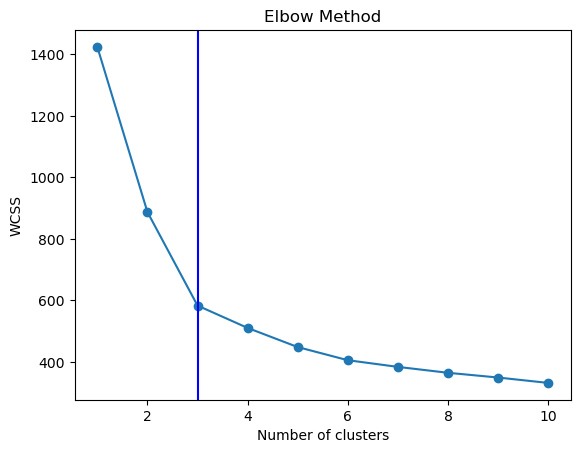

/Users/namgyulee/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namgyulee/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namgyulee/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namgyulee/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

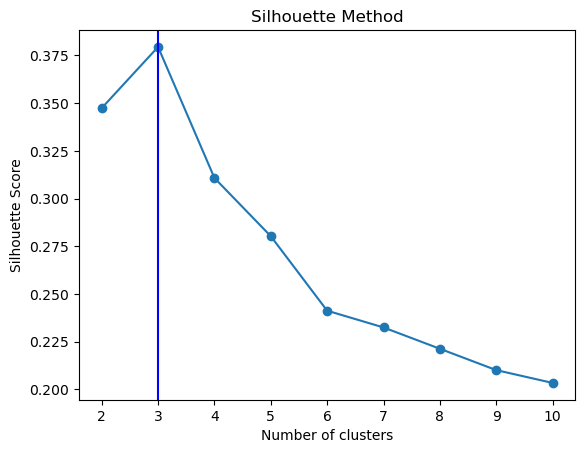

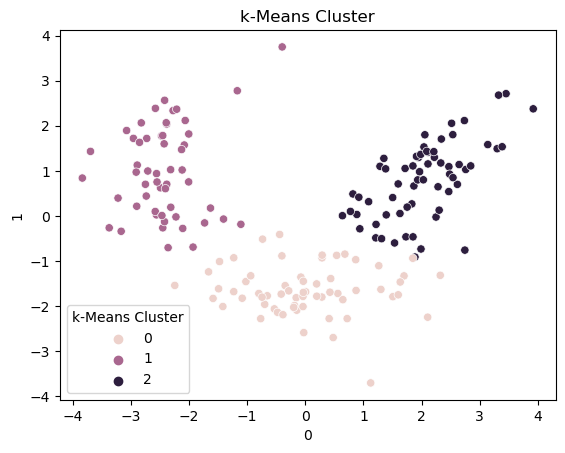

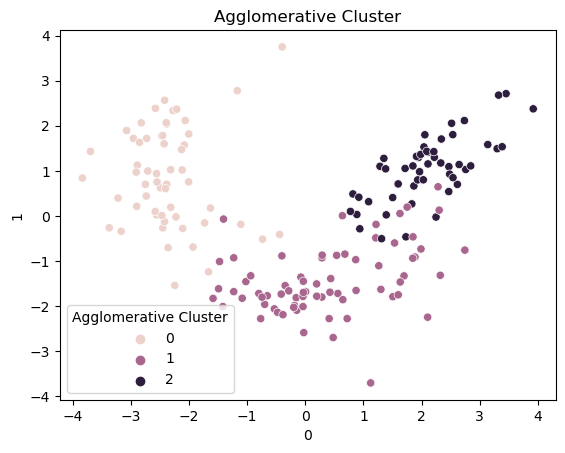

In [9]:
main('/Users/namgyulee/Personal_Project/ML_PaaS/data/wine-clustering.csv', 0.5, 'both', 2, 'yes')
